# Data Reproduction HierQ (Levy et al., 2019)

*Author*: Joery A. de Vries

**Structure of this notebook**:


In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

#### Libraries

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import evaluate, GenericOuterHook, benchmark
from mazelab_experimenter.utils import find

## Define Environments

In [3]:
t = 1000

name_four_rooms = EnvRegister.register(
    maze_type='four_rooms_HierQ', 
    name=f'four_rooms_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[3, 8]]
    ),
    time_limit=t,
    override=True
)

name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

Warning, room_size and gap_size are best kept as uniformly odd or even, not one odd one even.


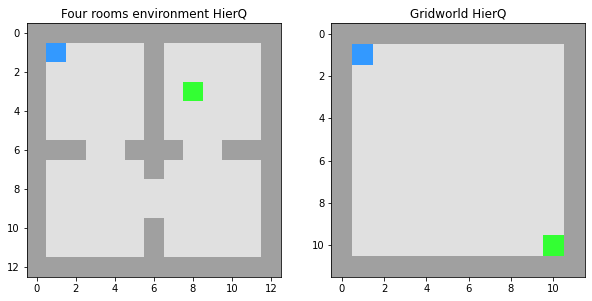

In [4]:
# Instantiate the registered MazeLab environment as a Gym environment.
four_rooms = gym.make(name_four_rooms)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = four_rooms.reset(), gridworld.reset()

img_a, img_b = four_rooms.unwrapped.get_image(), gridworld.unwrapped.get_image()

four_rooms.close()
gridworld.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("Four rooms environment HierQ")

axarr[1].imshow(img_b)
axarr[1].set_title("Gridworld HierQ")

plt.show()

## Benchmark HierQ

#### HierQ Documentation

In [5]:
AgentShelve.get_keyword_args('HierQ')

<Signature (observation_shape: Tuple, n_actions: int, n_levels: int, horizons: List[int], lr: float = 0.5, epsilon: float = 0.1, discount: float = 0.95, ignore_training_time: bool = False) -> None>

#### Define Agents

In [11]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    if n_levels > 1:
        agent = AgentShelve.retrieve(
            agent='HierQ',
            keyword_arguments=dict(
                observation_shape=_env.observation_space.shape,
                n_actions=_env.action_space.n,
                n_levels=n_levels,
                horizons=[horizon] * (n_levels - 1) + [200],
                lr=1, discount=1, epsilon=0.25
            ))
        agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    else:
        agent = AgentShelve.retrieve(
            agent='TabularQLearner', 
            keyword_arguments=dict(
            observation_shape = _env.observation_space.shape,
            n_actions = _env.action_space.n,
            q_init=0, discount=1, epsilon=0.25, lr=1
            ))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
        lambda: flat_agent(_env=dummy),
        lambda: hierq_l2(_env=dummy),
        lambda: hierq_l3(_env=dummy)
    ]

flat_agent = partial(gen_hierq, n_levels=1, horizon=None)
hierq_l2 = partial(gen_hierq, n_levels=2, horizon=3)
hierq_l3 = partial(gen_hierq, n_levels=3, horizon=3)

#### Run Benchmark

In [12]:
# Benchmark configuration
r = 5
it = 50
eps = 1
trials = 5
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_four_rooms, name_gridworld]:
    
    env_data = list()
    for agent_gen in get_agent_gen(env_name):
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

-- Benchmarking Repetition 1 / 5 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.85it/s]
-- Benchmarking Repetition 2 / 5 --- ETA: 0:00:42 --- Rate: 10 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.15it/s]
-- Benchmarking Repetition 3 / 5 --- ETA: 0:00:28 --- Rate: 9 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.32it/s]
-- Benchmarking Repetition 4 / 5 --- ETA: 0:00:20 --- Rate: 10 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]
-- Benchmarking Repetition 5 / 5 --- ETA: 0:00:10 --- Rate: 10 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.15it/s]
-- Benchmarking Repetition 1 / 5 --- ETA:  --- Rate: 0

## Plot Results

Helper functions.

In [8]:
def plot_progress(arr: np.ndarray, population_size: int, axis: int = 0, label: str = None) -> None:
    # Helper function for plotting.
    mean_length = arr[...,axis][...,0].mean(axis=0)
    std_length = arr[...,axis][...,0].std(axis=0) / np.sqrt(population_size)

    plt.plot(mean_length, label=label, linewidth=2)
    plt.fill_between(np.arange(len(mean_length)), mean_length + std_length, mean_length - std_length, alpha=0.1)
    
    
def manhattan_dist(c_a: np.ndarray, c_b: np.ndarray):
    # Helper function to compute the L1 distance between two arrays.
    return np.sum(np.abs(np.asarray(c_a) - np.asarray(c_b)))

#### Four-Rooms

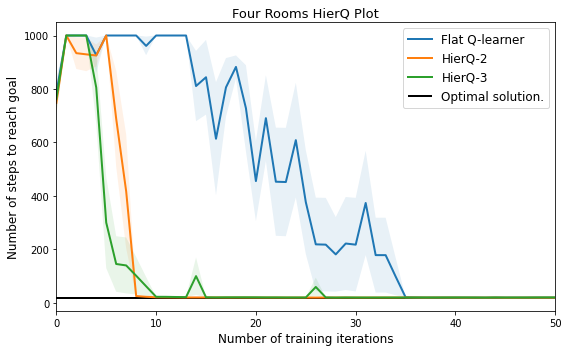

In [13]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], ['Flat Q-learner', r'HierQ-2', r'HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

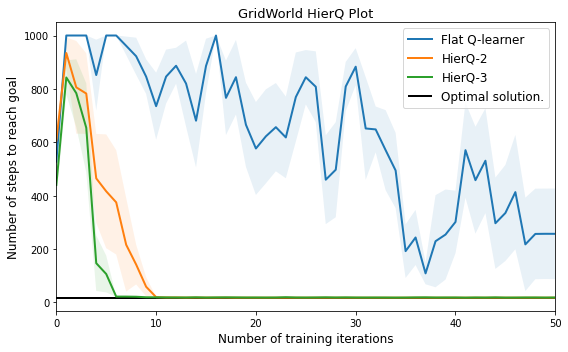

In [14]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], ['Flat Q-learner', r'HierQ-2', r'HierQ-3']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Conclusion